In [1]:
###### data loader####
#import clip
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi
import argparse
from torch import nn, optim
from torch.autograd import Variable, grad
from scipy import linalg as la
from transformers import CLIPProcessor, CLIPModel
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from torchvision import utils
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

torch.set_num_threads(5)   # Sets the number of threads used for intra-operations
torch.set_num_interop_threads(5)   # Sets the number of threads used for inter-operations

import open_clip


data_dir = r"../../../Dataset/data/waterbirds_v1.0"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 1




class PatchCorruptTransform:
    def __init__(self, num_patches=8, corrupt_patches=[18,19, 20,21,26,27,28,29,30,34,35,36,37]):
        """
        Args:
        num_patches (int): The total number of patches along one dimension. Total patches = num_patches * num_patches.
        corrupt_patches (list of int): Indices of the patches to corrupt.
        """
        self.num_patches = num_patches
        self.corrupt_patches = corrupt_patches

    def __call__(self, img):
        # Convert PIL image to tensor
        img = tfms.functional.to_tensor(img)
        c, h, w = img.shape
        patch_h, patch_w = h // self.num_patches, w // self.num_patches

        # Create patches
        patches = img.unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
        patches = patches.contiguous().view(c, -1, patch_h, patch_w)

        # Corrupt specified patches
        for idx in self.corrupt_patches:
            patch_mean = patches[:, idx].mean(dim=[1, 2], keepdim=True)
            patches[:, idx] = patch_mean.expand_as(patches[:, idx])

        # Reconstruct image from patches
        img = patches.view(c, self.num_patches, self.num_patches, patch_h, patch_w)
        img = img.permute(0, 1, 3, 2, 4).contiguous().view(c, h, w)
        return img


def get_transform_clip(train):
    patch_corupt = PatchCorruptTransform()
    transform = tfms.Compose([
        #tfms.RandomRotation((-90, 90)),
        #tfms.RandomHorizontalFlip(p=0.5),
        #tfms.GaussianBlur(kernel_size=(3, 3), sigma=(1, 2.0)),
        
        tfms.Resize((224,224), interpolation=tfms.InterpolationMode.BICUBIC),
        #patch_corupt,
        tfms.ToTensor(),
        tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform


model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')


# model,_, preprocess =  open_clip.create_model_and_transforms("ViT-B/32", pretrained='openai') #ViTB/32
# model = model.to(device)
# tokenizer = open_clip.get_tokenizer('ViT-B-32')



def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
class ConfounderDataset_train(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):
        raise NotImplementedError

    def __len__(self):
        return len(self.training_sample)

    def __getitem__(self, idx):
        y = self.training_sample_y_array[idx]
        a = self.training_sample_confounder_array[idx]
        img_filename = os.path.join(
            data_dir,
            self.training_sample[idx])       
        img = preprocess(Image.open(img_filename))
        #img = self.clip_transform(Image.open(img_filename))
        img_for_res = self.train_transform(Image.open(img_filename))
        return img,y,a, img_for_res

    
    
class CUBDataset_train(ConfounderDataset_train):
    """
    CUB dataset (already cropped and centered).
    Note: metadata_df is one-indexed.
    """
    def __init__(self):
        self.data_dir = os.path.join(
           data_dir)

        if not os.path.exists(self.data_dir):
            raise ValueError(
                f'{self.data_dir} does not exist yet. Please generate the dataset first.')

        # Read in metadata
        self.metadata_df = pd.read_csv(
            os.path.join(self.data_dir, 'metadata.csv'))

        # Get the y values
        self.y_array = self.metadata_df['y'].values
        self.n_classes = 2

        # We only support one confounder for CUB for now
        self.confounder_array = self.metadata_df['place'].values
        self.n_confounders = 1
        
        # Extract filenames and splits
        self.filename_array = self.metadata_df['img_filename'].values
        self.split_array = self.metadata_df['split'].values

        self.training_sample = self.filename_array[self.split_array == 0]
        self.training_sample_y_array = self.y_array[self.split_array == 0]
        self.training_sample_confounder_array =self.confounder_array[self.split_array == 0]
        self.train_transform = get_transform_cub(train=True)
        self.eval_transform = get_transform_cub(train=False)
        self.clip_transform = get_transform_clip(train=False)

class ConfounderDataset_test(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):
        raise NotImplementedError

    def __len__(self):
        return len(self.test_sample)

    def __getitem__(self, idx):
        y = self.test_sample_y_array[idx]
        a = self.test_sample_confounder_array[idx]
        img_filename = os.path.join(
            data_dir,
            self.test_sample[idx])       
        img = preprocess(Image.open(img_filename))
        img_for_res = self.eval_transform(Image.open(img_filename))
        return img,y,a, img_for_res
        
class CUBDataset_test(ConfounderDataset_test):
    def __init__(self):
        self.data_dir = os.path.join(
           data_dir,)

        if not os.path.exists(self.data_dir):
            raise ValueError(
                f'{self.data_dir} does not exist yet. Please generate the dataset first.')

        self.metadata_df = pd.read_csv(
            os.path.join(self.data_dir, 'metadata.csv'))
        self.y_array = self.metadata_df['y'].values
        self.n_classes = 2
        self.confounder_array = self.metadata_df['place'].values
        self.n_confounders = 1
        self.filename_array = self.metadata_df['img_filename'].values
        self.split_array = self.metadata_df['split'].values

        self.test_sample = self.filename_array[self.split_array == 2]
        self.test_sample_y_array = self.y_array[self.split_array == 2]
        self.test_sample_confounder_array =self.confounder_array[self.split_array == 2]
        self.eval_transform = get_transform_cub(train=False)
        self.clip_transform = get_transform_clip(train=False)


def get_transform_cub(train):
    transform = tfms.Compose([
        tfms.Resize((336,336)),
        tfms.ToTensor()
    ])
    return transform




training_dataset = CUBDataset_train()
test_dataset = CUBDataset_test()



training_data_loader  = torch.utils.data.DataLoader(dataset = training_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0,
                                                drop_last=True)

test_data_loader  = torch.utils.data.DataLoader(dataset = test_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0,
                                                drop_last=False)
print('Done')

Done


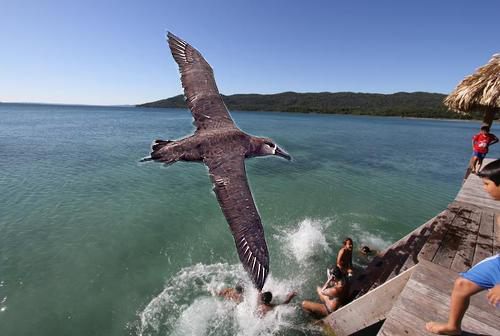

In [2]:
img_filename = os.path.join(
            data_dir,
            test_dataset.filename_array[1]) 
img = Image.open(img_filename)
img

bird_embeddings torch.Size([1, 768])


Testing:   0%|                                                                                 | 0/5794 [00:00<?, ?it/s]

tensor([1]) tensor([1])
step 0


<Figure size 500x500 with 0 Axes>

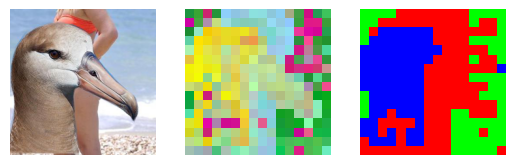

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

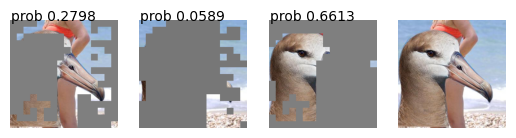

Testing:   0%|                                                                         | 1/5794 [00:00<29:48,  3.24it/s]

********************************************************************
tensor([1]) tensor([0])
step 1


<Figure size 500x500 with 0 Axes>

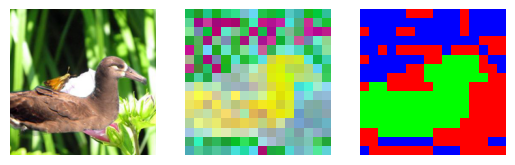

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

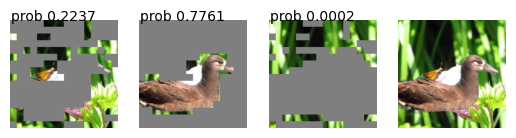

Testing:   0%|                                                                         | 2/5794 [00:00<21:01,  4.59it/s]

********************************************************************
tensor([1]) tensor([1])
step 2


<Figure size 500x500 with 0 Axes>

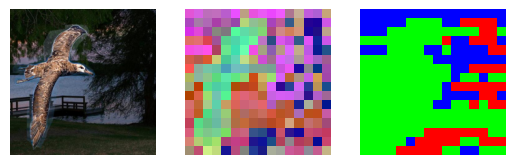

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

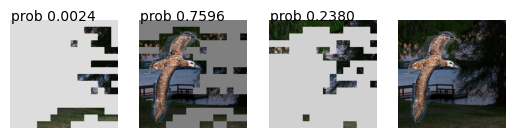

Testing:   0%|                                                                         | 3/5794 [00:00<25:07,  3.84it/s]

********************************************************************
tensor([1]) tensor([1])
step 3


<Figure size 500x500 with 0 Axes>

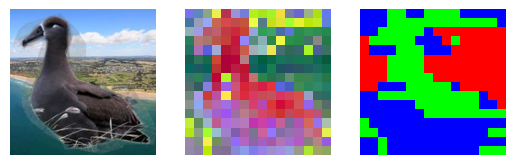

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

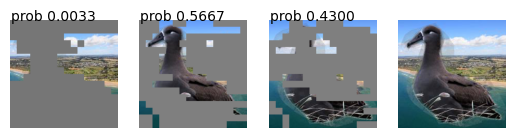

Testing:   0%|                                                                         | 4/5794 [00:00<20:47,  4.64it/s]

********************************************************************
tensor([1]) tensor([0])
step 4


<Figure size 500x500 with 0 Axes>

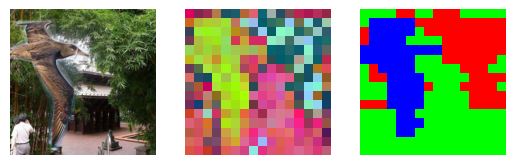

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

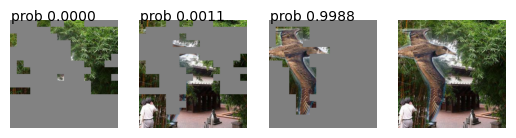

Testing:   0%|                                                                         | 5/5794 [00:01<18:29,  5.22it/s]

********************************************************************
tensor([1]) tensor([0])
step 5


<Figure size 500x500 with 0 Axes>

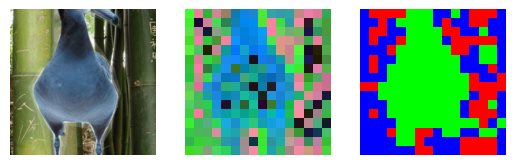

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

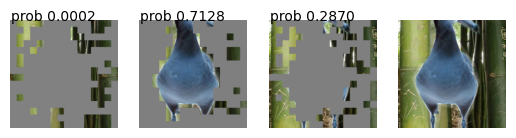

Testing:   0%|                                                                         | 6/5794 [00:01<17:13,  5.60it/s]

********************************************************************
tensor([1]) tensor([0])
step 6


<Figure size 500x500 with 0 Axes>

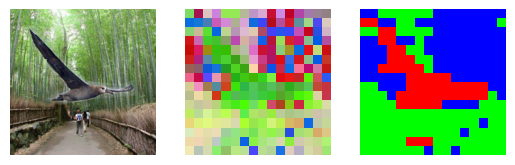

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

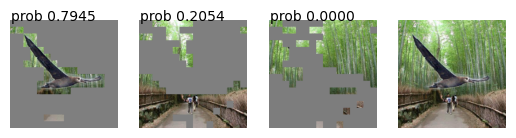

Testing:   0%|                                                                         | 7/5794 [00:01<16:22,  5.89it/s]

********************************************************************
tensor([1]) tensor([0])
step 7


<Figure size 500x500 with 0 Axes>

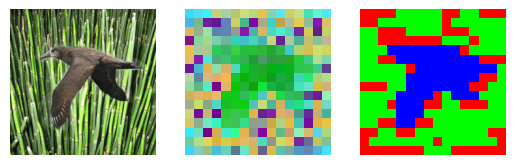

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

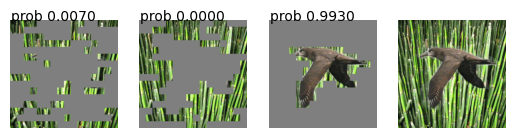

Testing:   0%|                                                                         | 8/5794 [00:01<15:45,  6.12it/s]

********************************************************************
tensor([1]) tensor([1])
step 8


<Figure size 500x500 with 0 Axes>

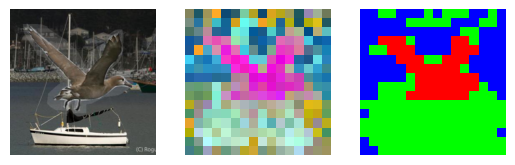

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

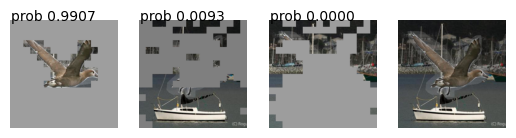

Testing:   0%|                                                                         | 9/5794 [00:01<15:25,  6.25it/s]

********************************************************************
tensor([1]) tensor([1])
step 9


<Figure size 500x500 with 0 Axes>

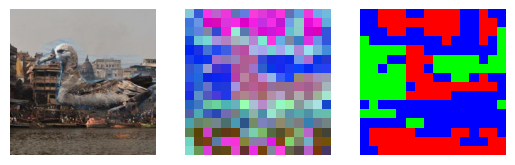

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

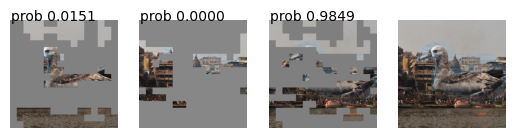

Testing:   0%|                                                                        | 10/5794 [00:01<15:07,  6.37it/s]

********************************************************************
tensor([1]) tensor([0])
step 10


<Figure size 500x500 with 0 Axes>

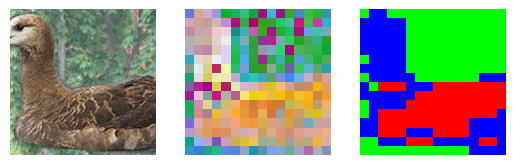

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

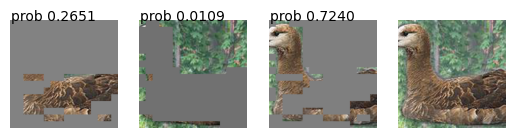

Testing:   0%|▏                                                                       | 11/5794 [00:02<19:53,  4.85it/s]

********************************************************************
tensor([1]) tensor([1])
step 11


<Figure size 500x500 with 0 Axes>

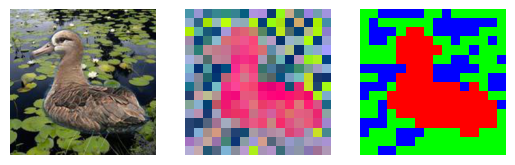

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

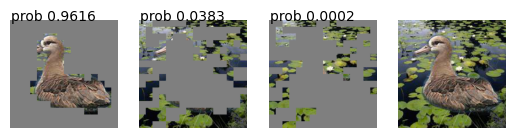

Testing:   0%|▏                                                                       | 12/5794 [00:02<18:03,  5.34it/s]

********************************************************************
tensor([1]) tensor([1])
step 12


<Figure size 500x500 with 0 Axes>

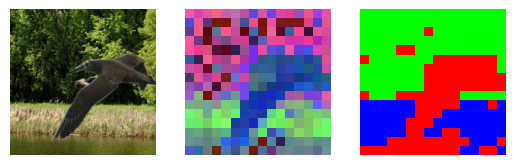

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

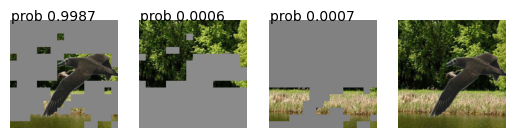

Testing:   0%|▏                                                                       | 13/5794 [00:02<16:55,  5.69it/s]

********************************************************************
tensor([1]) tensor([1])
step 13


<Figure size 500x500 with 0 Axes>

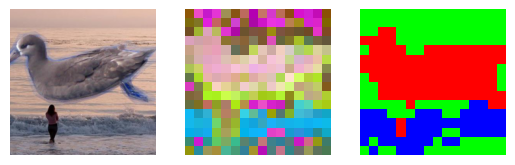

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

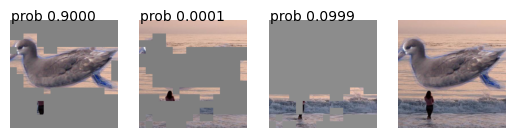

Testing:   0%|▏                                                                       | 14/5794 [00:02<16:10,  5.95it/s]

********************************************************************
tensor([1]) tensor([1])
step 14


<Figure size 500x500 with 0 Axes>

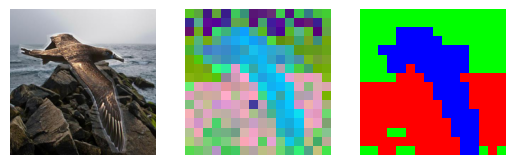

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

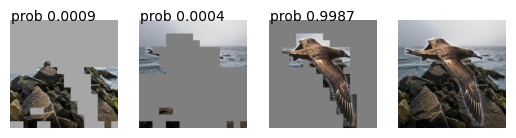

Testing:   0%|▏                                                                       | 15/5794 [00:02<15:35,  6.18it/s]

********************************************************************
tensor([1]) tensor([0])
step 15


<Figure size 500x500 with 0 Axes>

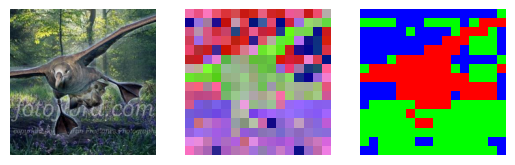

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

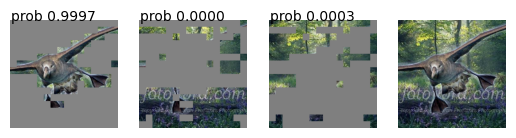

Testing:   0%|▏                                                                       | 16/5794 [00:02<15:11,  6.34it/s]

********************************************************************
tensor([1]) tensor([0])
step 16


<Figure size 500x500 with 0 Axes>

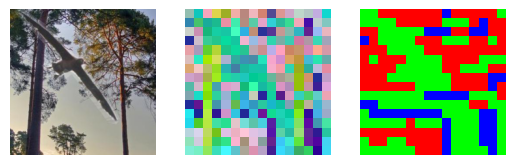

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

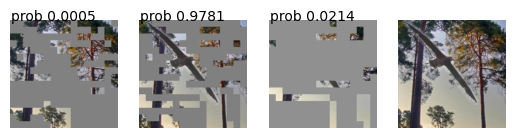

Testing:   0%|▏                                                                       | 17/5794 [00:03<14:55,  6.45it/s]

********************************************************************
tensor([1]) tensor([1])
step 17


<Figure size 500x500 with 0 Axes>

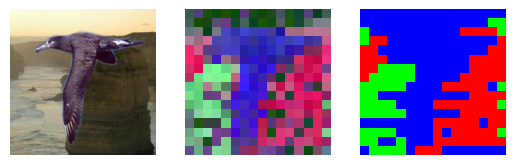

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

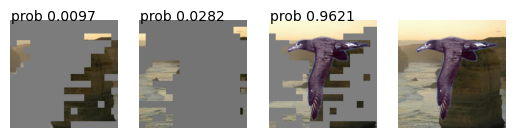

Testing:   0%|▏                                                                       | 18/5794 [00:03<15:03,  6.39it/s]

********************************************************************
tensor([1]) tensor([0])
step 18


<Figure size 500x500 with 0 Axes>

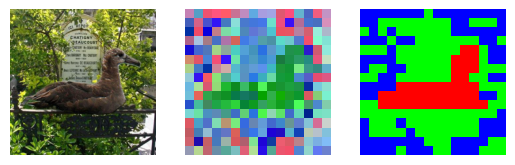

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

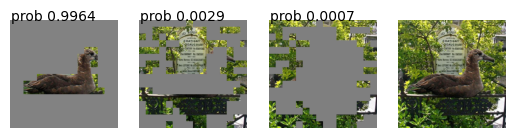

Testing:   0%|▏                                                                       | 19/5794 [00:03<20:08,  4.78it/s]

********************************************************************
tensor([1]) tensor([1])
step 19


<Figure size 500x500 with 0 Axes>

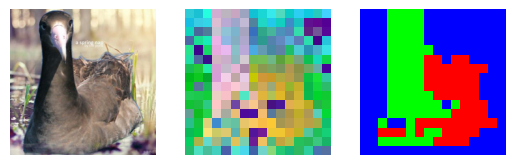

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

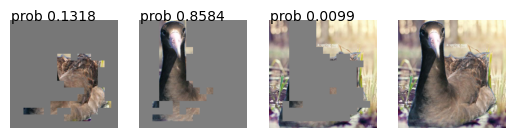

Testing:   0%|▏                                                                       | 20/5794 [00:03<18:26,  5.22it/s]

********************************************************************
tensor([1]) tensor([0])
step 20


<Figure size 500x500 with 0 Axes>

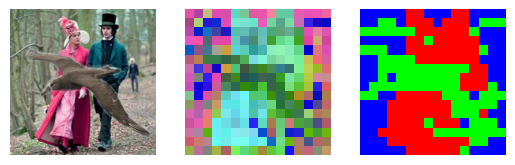

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

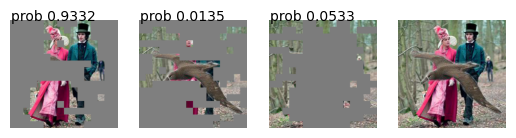

Testing:   0%|▎                                                                       | 21/5794 [00:03<17:25,  5.52it/s]

********************************************************************
tensor([1]) tensor([1])
step 21


<Figure size 500x500 with 0 Axes>

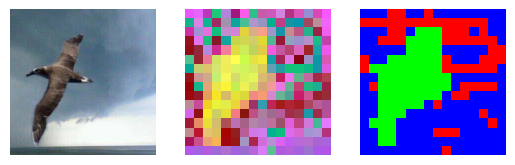

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

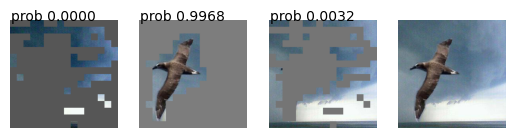

Testing:   0%|▎                                                                       | 22/5794 [00:03<16:49,  5.72it/s]

********************************************************************
tensor([1]) tensor([0])
step 22


<Figure size 500x500 with 0 Axes>

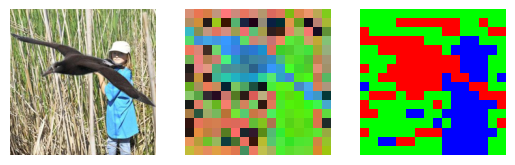

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

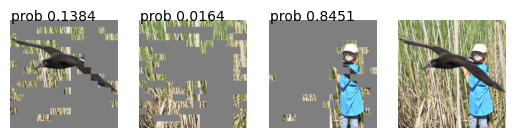

Testing:   0%|▎                                                                       | 23/5794 [00:04<16:18,  5.90it/s]

********************************************************************
tensor([1]) tensor([0])
step 23


<Figure size 500x500 with 0 Axes>

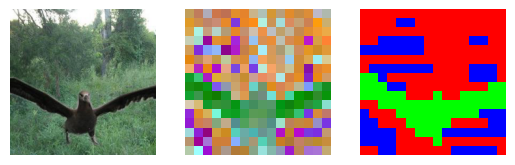

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

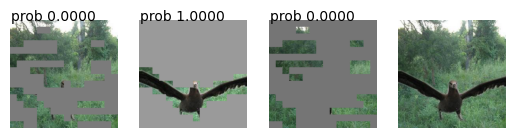

Testing:   0%|▎                                                                       | 24/5794 [00:04<16:05,  5.98it/s]

********************************************************************
tensor([1]) tensor([0])
step 24


<Figure size 500x500 with 0 Axes>

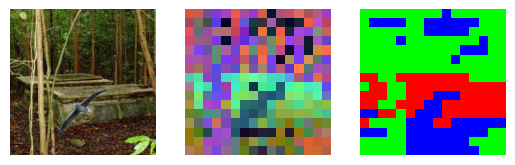

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

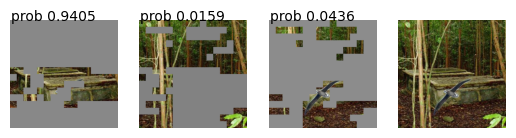

Testing:   0%|▎                                                                       | 25/5794 [00:04<15:34,  6.17it/s]

********************************************************************
tensor([1]) tensor([0])
step 25


<Figure size 500x500 with 0 Axes>

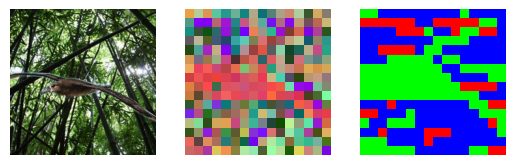

Segmentation label tensor([1], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

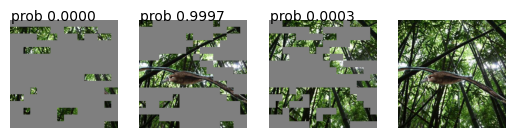

Testing:   0%|▎                                                                       | 26/5794 [00:04<15:09,  6.34it/s]

********************************************************************
tensor([1]) tensor([0])
step 26


<Figure size 500x500 with 0 Axes>

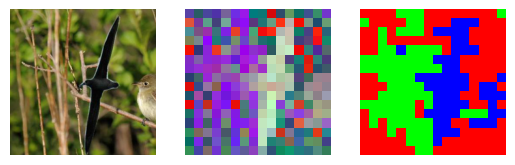

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

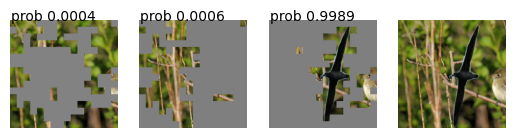

Testing:   0%|▎                                                                       | 27/5794 [00:04<20:39,  4.65it/s]

********************************************************************
tensor([1]) tensor([1])
step 27


<Figure size 500x500 with 0 Axes>

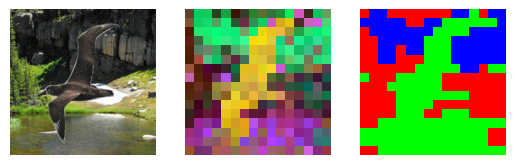

Segmentation label tensor([2], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

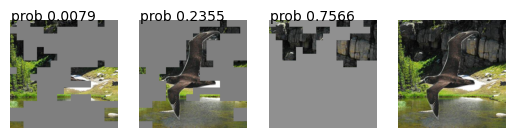

Testing:   0%|▎                                                                       | 28/5794 [00:05<19:01,  5.05it/s]

********************************************************************
tensor([1]) tensor([0])
step 28


<Figure size 500x500 with 0 Axes>

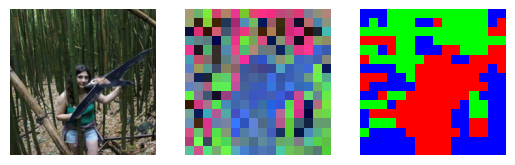

Segmentation label tensor([0], device='cuda:1')


<Figure size 1000x500 with 0 Axes>

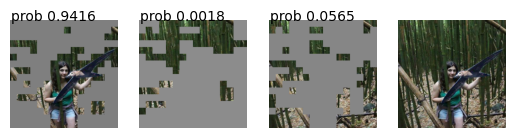

Testing:   0%|▎                                                                       | 28/5794 [00:05<18:06,  5.31it/s]

********************************************************************


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import PCA_Vis
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque


queue_length = 0

def pca_single_modality(pca_features, mask, n_imgs, img):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 3)
        img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
        image_np = to_pil_image(img[i].cpu().squeeze(0))
        ax[0].imshow(image_np)    
        print(pca_features[i*16*16 :(i+1)*16*16, :].shape)
        image_pca = torch.tensor(pca_features[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))                    
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))
    plt.show()
    plt.close()



def pca_single_modality_queue(pca_features, mask, n_imgs, img, id):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    fig, ax = plt.subplots(1, 3)
    img = (img - img.min()) / (img.max() - img.min())
    image_np = to_pil_image(img.cpu().squeeze(0))
    ax[0].imshow(image_np)  
    ax[0].axis('off')

    if id < queue_length:
        image_pca = torch.tensor(pca_features[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3))    
    else:
        image_pca = torch.tensor(pca_features[-16*16 :, :].reshape(16,16, 3))                    
    ax[1].imshow(image_pca.cpu().numpy())
    ax[1].axis('off')
    if id < queue_length:
        mask_tensor = mask[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3)
    else:
        mask_tensor = mask[-16*16 :, :].reshape(16,16, 3)
    ax[2].imshow(mask_tensor)
    ax[2].axis('off')
    plt.show()
    plt.close()
    return mask_tensor


def masked_img(image, mask, imshow, prob):  # image: (3, 224, 224), mask: (16, 16, 3)
    to_pil_image = tfms.ToPILImage()
    mask_single_channel = torch.argmax(mask, dim=-1)  # Shape: [16, 16]
    mask_upsampled = F.interpolate(mask_single_channel.unsqueeze(0).unsqueeze(0).float(),
                                    size=(224, 224), mode="nearest").squeeze().long()  # Shape: [224, 224]
    binary_masks = [(mask_upsampled == value).float() for value in range(3)]
    masked_images = [image * binary_mask.unsqueeze(0) for binary_mask in binary_masks]
    normalized_images = []
    for masked_image in masked_images:
        if masked_image.max() > masked_image.min():
            normalized_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
        else:
            normalized_image = masked_image  # No normalization needed if uniform
        normalized_images.append(normalized_image)
    if imshow == True:
        plt.figure(figsize=(10, 5))
        fig, ax = plt.subplots(1, 4)
        for i in range(3):
            image_np = to_pil_image(normalized_images[i].squeeze(0).cpu())
            ax[i].imshow(image_np)
            ax[i].axis('off')
            ax[i].text(1, 0.5, f"prob {prob[i].item():.4f}", fontsize=10)
        img = (image - image.min()) / (image.max() - image.min())
        image_np_o = to_pil_image(img.cpu().squeeze(0))
        ax[3].imshow(image_np_o) 
        ax[3].axis('off')
        plt.show()
    return normalized_images
    

def my_convert_ids_to_tokens(tokenizer, token_ids):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    tokens = []
    for tid in token_ids:
        if tid in tokenizer.decoder:
            tokens.append(tokenizer.decoder[tid])
        else:
            tokens.append(f"[UNK_{tid}]")
    return tokens






def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    visual = vlm.visual
    vlm.visual.pool_type = None
    vlm.text_pool_type = 'last'
    T =1
    texts_label = ["a photo of a landbird.", "a photo of a waterbird."] 
    bird_label = ["a photo of a bird."]
    text_label_tokened = tokenizer(texts_label).to(device)
    bird_label_tokened = tokenizer(bird_label).to(device)
    tokenizer.decoder[49406] = "<start>"
    tokenizer.decoder[49407] = "<end>"
    position_tokened = torch.tensor([
        [49406] + [0] * 7 + [49407] + [0] *68,
        [49406] + [0] * 7 + [49407] + [0] *68], device='cuda:1')
    length = 20
    text_embeddings = vlm.encode_text(text_label_tokened)
    bird_embeddings = vlm.encode_text(bird_label_tokened)
    print('bird_embeddings', bird_embeddings.shape)

    iteration = 0
    queue = deque()
    pca = PCA(n_components=3)
    segment_num = 3
    
    for _, (sample, _, _, _) in enumerate(tqdm(dataloader, desc="Testing")):
        sample = sample.to(device)
        img_embeds = vlm.encode_image(sample)[:,1:,:].squeeze(0)  #torch.Size([1, 257, 768])
        img_embeds = img_embeds.detach().cpu().numpy()   
        queue.append(img_embeds)
        iteration += 1
        if iteration> queue_length:
            break
            
    iteration = 0
    for step, (test_input, test_target, sensitive_real, _) in enumerate(tqdm(dataloader, desc="Testing")):
        print(test_target, sensitive_real)
        with torch.no_grad():
            print('step',step)        
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()      
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            comb_feature_gpu = img_embeddings[:,1:,:].squeeze(0)
            comb_feature = comb_feature_gpu.detach().cpu().numpy() 
            
            if step < queue_length:
                combined_array = np.vstack(queue)
                
            else:            
                queue.popleft()
                queue.append(comb_feature)
                combined_array = np.vstack(queue)

            pca.fit(combined_array)
            pca_features = pca.transform(combined_array)
            smoothed_data = gaussian_filter(pca_features, sigma=(0.85, 0))
            kmean_cluster = KMeans(n_clusters=segment_num, random_state=0, n_init="auto").fit_predict(smoothed_data)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_mask = encoder.fit_transform(kmean_cluster.reshape(-1, 1))
            pca_features_rgb = pca_features.copy()
            mask = pca_single_modality_queue(pca_features_rgb, one_hot_mask, batch_size, test_input, step)
            msks = masked_img(test_input.cpu(), torch.tensor(mask).cpu(), False, None)
            mask_single_channel = torch.argmax(torch.tensor(mask).cpu(), dim=-1).view(16, 16).contiguous().view(-1)
            local_rep = [comb_feature_gpu[mask_single_channel==i] for i in range(segment_num)]
            seg_embedding = torch.vstack([torch.mean(local_rep[i], dim=0, keepdim = True) for i in range(segment_num)])
            if torch.isnan(seg_embedding).any():
                valid_values = seg_embedding[~torch.isnan(seg_embedding)]
                if valid_values.numel() > 0:  # Ensure there are valid values
                    max_value = torch.max(valid_values)  # Get max of valid values
                    seg_embedding = torch.where(torch.isnan(seg_embedding), max_value, seg_embedding)
            seg_cosine_similarity = torch.mm(-seg_embedding, bird_embeddings.t())
            probs = seg_cosine_similarity.softmax(dim = 0)
            conf, predic = torch.max(probs.data, 0)
            print('Segmentation label', predic)
            masked_img(test_input.cpu(), torch.tensor(mask).cpu(), True, probs)
            print('********************************************************************')
            iteration +=1 
            if iteration > 28:
                break


seed_everything(2048)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)